# Setup & Load Datasets

In [29]:
%matplotlib inline

In [30]:
# --- Setup ---
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# --- Paths ---
base = Path.cwd().parent
processed_path = base / "data" / "processed"

# --- Load datasets ---
X_structured = pd.read_parquet(processed_path / "youtube_features_structured.parquet")
X_text = pd.read_parquet(processed_path / "youtube_features_text.parquet")
X_image = pd.read_parquet(processed_path / "youtube_features_image.parquet")
y_reg = pd.read_parquet(processed_path / "youtube_target_regression.parquet")["views_per_subscriber"]
y_clf = pd.read_parquet(processed_path / "youtube_target_classification.parquet")["high_clickability"]

print("Structured:", X_structured.shape)
print("Text:", X_text.shape)
print("Image:", X_image.shape)
print("Regression target:", y_reg.shape)
print("Classification target:", y_clf.shape)

Structured: (5742, 9)
Text: (5742, 50)
Image: (5742, 50)
Regression target: (5742,)
Classification target: (5742,)


# Combine Structured + Text Features

In [31]:
# --- Combine both sets for hybrid models ---
X_combined = pd.concat([X_structured.reset_index(drop=True), X_text.reset_index(drop=True), X_image.reset_index(drop=True)], axis=1)
print("Combined feature matrix:", X_combined.shape)

Combined feature matrix: (5742, 109)


# Train/Test Split

In [32]:
# --- Split datasets (same seed for comparability) ---
X_train_s, X_test_s, y_train_reg, y_test_reg = train_test_split(
    X_structured, y_reg, test_size=0.2, random_state=42
)
X_train_t, X_test_t, _, _ = train_test_split(
    X_text, y_reg, test_size=0.2, random_state=42
)
X_train_c, X_test_c, _, _ = train_test_split(
    X_combined, y_reg, test_size=0.2, random_state=42
)

# Scale structured data for linear models
scaler = StandardScaler()
X_train_s_scaled = scaler.fit_transform(X_train_s)
X_test_s_scaled = scaler.transform(X_test_s)

print("✅ Split and scaled data.")

✅ Split and scaled data.


# Regression Models

# Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_s_scaled, y_train_reg)

y_pred_lin = linreg.predict(X_test_s_scaled)

r2 = r2_score(y_test_reg, y_pred_lin)
mae = mean_absolute_error(y_test_reg, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_lin))

print("✅ Linear Regression (Structured Only)")
print("R²:", round(r2, 3))
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))

✅ Linear Regression (Structured Only)
R²: 0.024
MAE: 14.726
RMSE: 43.486


# Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_c, y_train_reg)  # use combined features

y_pred_rf = rf_reg.predict(X_test_c)

r2_rf = r2_score(y_test_reg, y_pred_rf)
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))

print("✅ Random Forest Regressor (Combined)")
print("R²:", round(r2_rf, 3))
print("MAE:", round(mae_rf, 3))
print("RMSE:", round(rmse_rf, 3))

✅ Random Forest Regressor (Combined)
R²: 0.259
MAE: 10.418
RMSE: 37.906


# XGBoost Regressor

In [35]:
try:
    from xgboost import XGBRegressor

    xgb_reg = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_reg.fit(X_train_c, y_train_reg)

    y_pred_xgb = xgb_reg.predict(X_test_c)

    r2_xgb = r2_score(y_test_reg, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test_reg, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))

    print("✅ XGBoost Regressor (Combined)")
    print("R²:", round(r2_xgb, 3))
    print("MAE:", round(mae_xgb, 3))
    print("RMSE:", round(rmse_xgb, 3))
except ImportError:
    print("⚠️ XGBoost not installed — skipping.")


✅ XGBoost Regressor (Combined)
R²: 0.207
MAE: 10.699
RMSE: 39.196


# Regression Results Comparison

In [36]:
import pandas as pd

reg_results = pd.DataFrame([
    ["Linear (Structured)", r2, mae, rmse],
    ["Random Forest (Combined)", r2_rf, mae_rf, rmse_rf],
    ["XGBoost (Combined)", r2_xgb if 'r2_xgb' in locals() else None,
     mae_xgb if 'mae_xgb' in locals() else None,
     rmse_xgb if 'rmse_xgb' in locals() else None]
], columns=["Model", "R²", "MAE", "RMSE"])

print(reg_results)

                      Model        R²        MAE       RMSE
0       Linear (Structured)  0.024263  14.726419  43.486132
1  Random Forest (Combined)  0.258597  10.417909  37.906304
2        XGBoost (Combined)  0.207293  10.698660  39.195903


# Classification Models

# Train/Test Split for Classification

In [37]:
X_train_cclf, X_test_cclf, y_train_clf, y_test_clf = train_test_split(
    X_combined, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Logistic Regression Classifier

In [38]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
log_clf.fit(X_train_cclf, y_train_clf)

y_pred_clf = log_clf.predict(X_test_cclf)
y_prob_clf = log_clf.predict_proba(X_test_cclf)[:, 1]

acc = accuracy_score(y_test_clf, y_pred_clf)
prec = precision_score(y_test_clf, y_pred_clf)
rec = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)
roc = roc_auc_score(y_test_clf, y_prob_clf)

print("✅ Logistic Regression (Combined)")
print("Accuracy:", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall:", round(rec, 3))
print("F1-score:", round(f1, 3))
print("ROC-AUC:", round(roc, 3))

✅ Logistic Regression (Combined)
Accuracy: 0.763
Precision: 0.581
Recall: 0.188
F1-score: 0.284
ROC-AUC: 0.777


# Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

# rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_estimators=200
)
rf_clf.fit(X_train_cclf, y_train_clf)

y_pred_rf_clf = rf_clf.predict(X_test_cclf)
y_prob_rf_clf = rf_clf.predict_proba(X_test_cclf)[:, 1]

acc_rf = accuracy_score(y_test_clf, y_pred_rf_clf)
prec_rf = precision_score(y_test_clf, y_pred_rf_clf)
rec_rf = recall_score(y_test_clf, y_pred_rf_clf)
f1_rf = f1_score(y_test_clf, y_pred_rf_clf)
roc_rf = roc_auc_score(y_test_clf, y_prob_rf_clf)

print("✅ Random Forest Classifier (Combined)")
print("Accuracy:", round(acc_rf, 3))
print("Precision:", round(prec_rf, 3))
print("Recall:", round(rec_rf, 3))
print("F1-score:", round(f1_rf, 3))
print("ROC-AUC:", round(roc_rf, 3))

✅ Random Forest Classifier (Combined)
Accuracy: 0.791
Precision: 0.712
Recall: 0.275
F1-score: 0.397
ROC-AUC: 0.859


# Classification Results Summary

In [40]:
clf_results = pd.DataFrame([
    ["Logistic Regression", acc, prec, rec, f1, roc],
    ["Random Forest", acc_rf, prec_rf, rec_rf, f1_rf, roc_rf]
], columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC"])

print(clf_results)

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.763272   0.580645  0.188153  0.284211  0.777016
1        Random Forest  0.791123   0.711712  0.275261  0.396985  0.858705


# Visualizations

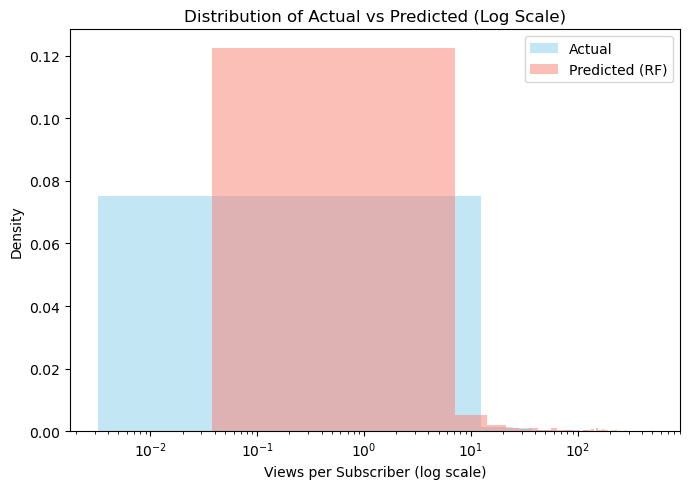

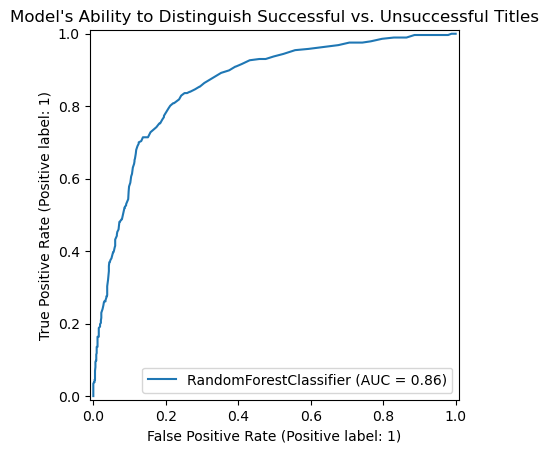

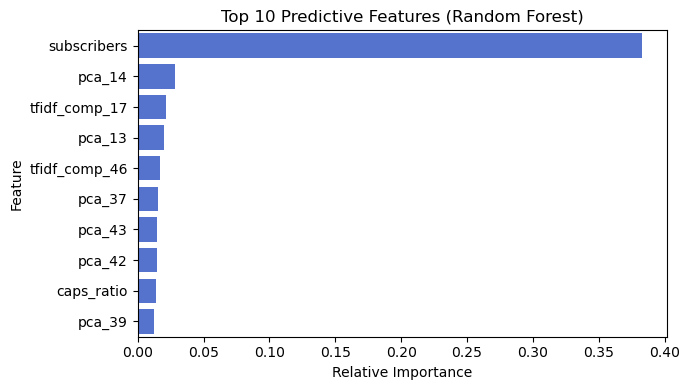


Top 10 Most Important Features:
subscribers      0.382844
pca_14           0.028501
tfidf_comp_17    0.021105
pca_13           0.020223
tfidf_comp_46    0.016611
pca_37           0.015622
pca_43           0.014821
pca_42           0.014820
caps_ratio       0.013473
pca_39           0.012535
dtype: float64


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Regression: predicted vs actual ---
plt.figure(figsize=(7,5))
plt.hist(y_test_reg, bins=40, alpha=0.5, label="Actual", color="skyblue", density=True)
plt.hist(y_pred_rf, bins=40, alpha=0.5, label="Predicted (RF)", color="salmon", density=True)
plt.xscale("log")
plt.xlabel("Views per Subscriber (log scale)")
plt.ylabel("Density")
plt.title("Distribution of Actual vs Predicted (Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Classification: Random Forest Classifier ROC Curve ---
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf_clf, X_test_cclf, y_test_clf)
plt.title("Model's Ability to Distinguish Successful vs. Unsuccessful Titles")
plt.show()

# --- Feature Importance ---
importances = pd.Series(rf_reg.feature_importances_, index=X_train_c.columns)
top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(7,4))
sns.barplot(x=top10.values, y=top10.index, color="royalblue")
plt.title("Top 10 Predictive Features (Random Forest)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(top10)